In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
%matplotlib inline

import glob
import sklearn
import torch
import torch.nn as nn

In [2]:
files = sorted(glob.glob('data/lstm/*.csv.gz'))

In [3]:
df = pd.concat(map(pd.read_csv, files))

In [4]:
df = df[df.symbol == 'XBTUSD']

In [5]:
# covert to timestamp type
df.timestamp = pd.to_datetime(df.timestamp.str.replace('D', 'T'))

In [6]:
df = df.sort_values('timestamp')

In [7]:
# set index to timestamp
df.set_index('timestamp', inplace=True)

In [8]:
df.head()

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
timestamp,,,,,,,,,
2020-04-20 00:00:02.998482,XBTUSD,Sell,57,7125.0,MinusTick,c38376c2-d09f-5ba7-30f5-0542e4ea7542,799995,0.008000,57.0
2020-04-20 00:00:03.001833,XBTUSD,Sell,25,7125.0,ZeroMinusTick,e205390b-3fdd-0df1-4d5f-a934d4124b31,350875,0.003509,25.0
2020-04-20 00:00:03.090244,XBTUSD,Sell,3227,7125.0,ZeroMinusTick,68017e6c-3e05-a5c7-c397-e0ef60c07ed3,45290945,0.452909,3227.0
2020-04-20 00:00:03.429719,XBTUSD,Sell,10,7125.0,ZeroMinusTick,95022e39-2e92-da87-1543-ab78b6dcc5fa,140350,0.001404,10.0
2020-04-20 00:00:03.648011,XBTUSD,Sell,18,7125.0,ZeroMinusTick,db8d2723-4c55-eac8-b696-ce1b4df4d4b8,252630,0.002526,18.0


In [9]:
df_vwap = df.groupby(pd.Grouper(freq="1Min")).apply(
    lambda row: np.sum(row.price * row.foreignNotional) / np.sum(row.foreignNotional))

In [10]:
df_vwap

timestamp
2020-04-20 00:00:00    7125.932850
2020-04-20 00:01:00    7121.392883
2020-04-20 00:02:00    7101.023068
2020-04-20 00:03:00    7109.457426
2020-04-20 00:04:00    7114.023479
                          ...     
2020-04-22 23:55:00    7120.261463
2020-04-22 23:56:00    7120.086473
2020-04-22 23:57:00    7122.948857
2020-04-22 23:58:00    7128.706494
2020-04-22 23:59:00    7132.717193
Length: 4320, dtype: float64

In [11]:
df = df_vwap.reset_index()

In [12]:
df.columns

Index(['timestamp', 0], dtype='object')

In [13]:
df.rename({0 : 'price'}, axis=1, inplace=True)

In [14]:
df.shape

(4320, 2)

In [15]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

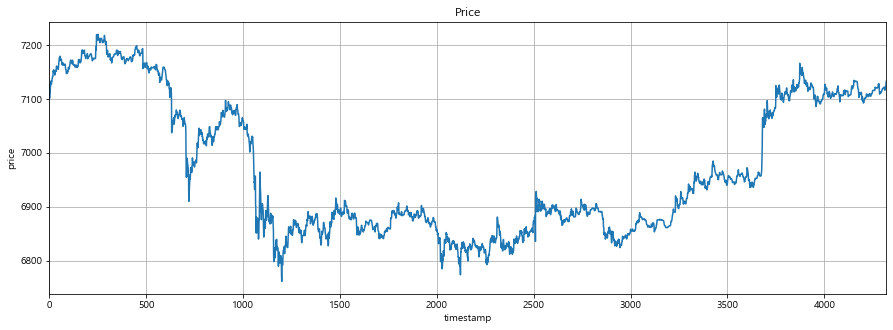

In [16]:
plt.title('Price')
plt.ylabel('price')
plt.xlabel('timestamp')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['price'])

# Data Preprocessing

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)
test_arr = scaler.transform(df_test)

NameError: name 'df_train' is not defined

In [17]:
df.columns

Index(['timestamp', 'price'], dtype='object')

In [18]:
all_data = df['price'].values.astype(float)

In [19]:
print(all_data)

[7125.93285037 7121.39288292 7101.02306779 ... 7122.94885677 7128.70649433
 7132.71719334]


In [20]:
len(all_data) * 0.1

432.0

In [21]:
# test 데이터의 크기 지정

test_data_size = 432

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [22]:
print("length of train data : %s" % len(train_data))
print("length of test data : %s" % len(test_data))
print(test_data[:10])

length of train data : 3888
length of test data : 432
[7147.43955003 7149.00580814 7148.34103812 7145.32729912 7143.69732216
 7141.99903275 7140.74272053 7137.7169895  7132.98061297 7128.45268853]


In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [24]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[0.59125371]
 [0.57144658]
 [0.48257642]
 [0.51937414]
 [0.53929508]]
[[0.66656225]
 [0.66828749]
 [0.71687424]
 [0.73276037]
 [0.70571477]]


In [25]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
#train_data_normalized = train_data_normalized.cuda()

In [26]:
train_data_normalized[:5]

tensor([0.5913, 0.5714, 0.4826, 0.5194, 0.5393])

In [27]:
# 몇개 씩 묶어서 학습을 할 것인가를 설정
train_window = 54

In [28]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [29]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [32]:
train_inout_seq[:5]

[(tensor([0.5913, 0.5714, 0.4826, 0.5194, 0.5393, 0.5319, 0.5628, 0.6074, 0.6159,
          0.6221, 0.5943, 0.5953, 0.6081, 0.6138, 0.6207, 0.6363, 0.6487, 0.6582,
          0.6574, 0.6576, 0.6804, 0.7045, 0.6954, 0.7125, 0.7031, 0.7077, 0.6979,
          0.6958, 0.6862, 0.6705, 0.6819, 0.6998, 0.6980, 0.7067, 0.6985, 0.7039,
          0.7121, 0.7376, 0.7436, 0.7419, 0.7399, 0.7346, 0.7267, 0.7265, 0.7244,
          0.7189, 0.7162, 0.7168, 0.7395, 0.7740, 0.7756, 0.7942, 0.8091, 0.8082]),
  tensor([0.8131])),
 (tensor([0.5714, 0.4826, 0.5194, 0.5393, 0.5319, 0.5628, 0.6074, 0.6159, 0.6221,
          0.5943, 0.5953, 0.6081, 0.6138, 0.6207, 0.6363, 0.6487, 0.6582, 0.6574,
          0.6576, 0.6804, 0.7045, 0.6954, 0.7125, 0.7031, 0.7077, 0.6979, 0.6958,
          0.6862, 0.6705, 0.6819, 0.6998, 0.6980, 0.7067, 0.6985, 0.7039, 0.7121,
          0.7376, 0.7436, 0.7419, 0.7399, 0.7346, 0.7267, 0.7265, 0.7244, 0.7189,
          0.7162, 0.7168, 0.7395, 0.7740, 0.7756, 0.7942, 0.8091, 0.8082, 0

# Creating LSTM Model

In [30]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [31]:
model = LSTM()
model = model.cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


# Training the Model

In [33]:
is_cuda = torch.cuda.is_available()
is_cuda

True

In [35]:
from tqdm import tqdm

In [38]:
epochs = 150

for i in tqdm(range(epochs)):
    for seq, labels in train_inout_seq:
        if is_cuda:
            seq, labels = seq.cuda(), labels.cuda()
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).cuda(),
                        torch.zeros(1, 1, model.hidden_layer_size).cuda())

        y_pred = model(seq).cuda()

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

  1%|▏         | 2/150 [01:16<1:35:05, 38.55s/it]

epoch:   1 loss: 0.00000634


 18%|█▊        | 27/150 [17:46<1:18:22, 38.23s/it]

epoch:  26 loss: 0.00038306


 35%|███▍      | 52/150 [38:54<1:24:42, 51.86s/it]

epoch:  51 loss: 0.00060494


 51%|█████▏    | 77/150 [58:17<54:06, 44.48s/it]  

epoch:  76 loss: 0.00063563


 68%|██████▊   | 102/150 [1:16:03<34:04, 42.58s/it]

epoch: 101 loss: 0.00150395


 85%|████████▍ | 127/150 [1:33:47<16:19, 42.58s/it]

epoch: 126 loss: 0.00150136


100%|██████████| 150/150 [1:50:24<00:00, 44.16s/it]

epoch: 149 loss: 0.0004088187


# Making Predictions

In [39]:
fut_pred = 216

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.5911096334457397, 0.5642001628875732, 0.561943531036377, 0.564515233039856, 0.5723224878311157, 0.5799384713172913, 0.6327614784240723, 0.5386930108070374, 0.5531030893325806, 0.5468667149543762, 0.5337039828300476, 0.548136293888092, 0.5742720365524292, 0.5595731139183044, 0.5471099615097046, 0.5481463670730591, 0.5451363325119019, 0.5421842932701111, 0.5414146184921265, 0.545111358165741, 0.5645518898963928, 0.554246187210083, 0.5623394250869751, 0.5749273300170898, 0.5921990871429443, 0.5944204926490784, 0.582623302936554, 0.5657342076301575, 0.5768968462944031, 0.5806953310966492, 0.5758360028266907, 0.5851050615310669, 0.5808143615722656, 0.5758612155914307, 0.600566565990448, 0.6090009212493896, 0.6083246469497681, 0.6275121569633484, 0.6349626779556274, 0.7656219601631165, 0.707920253276825, 0.7048172354698181, 0.6816239953041077, 0.6844449639320374, 0.6782359480857849, 0.6944351196289062, 0.6986495852470398, 0.6876792311668396, 0.6753692626953125, 0.6665622591972351, 0.66828

In [43]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    seq = seq.cuda()
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).cuda(),
                        torch.zeros(1, 1, model.hidden_layer_size).cuda())
        test_inputs.append(model(seq).item())

In [46]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions[:5])

[[7154.12795722]
 [7155.95318766]
 [7158.21510721]
 [7158.06974455]
 [7158.65089464]]


In [ ]:
216

In [47]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


In [50]:
x

array([132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143])

In [54]:
df

,timestamp,price
0,2020-04-20 00:00:00,7125.932850
1,2020-04-20 00:01:00,7121.392883
2,2020-04-20 00:02:00,7101.023068
3,2020-04-20 00:03:00,7109.457426
4,2020-04-20 00:04:00,7114.023479
...,...,...
4315,2020-04-22 23:55:00,7120.261463
4316,2020-04-22 23:56:00,7120.086473
4317,2020-04-22 23:57:00,7122.948857
4318,2020-04-22 23:58:00,7128.706494


In [60]:
s = len(df['timestamp']) - 216
df['timestamp'][s:]

4104   2020-04-22 20:24:00
4105   2020-04-22 20:25:00
4106   2020-04-22 20:26:00
4107   2020-04-22 20:27:00
4108   2020-04-22 20:28:00
               ...        
4315   2020-04-22 23:55:00
4316   2020-04-22 23:56:00
4317   2020-04-22 23:57:00
4318   2020-04-22 23:58:00
4319   2020-04-22 23:59:00
Name: timestamp, Length: 216, dtype: datetime64[ns]

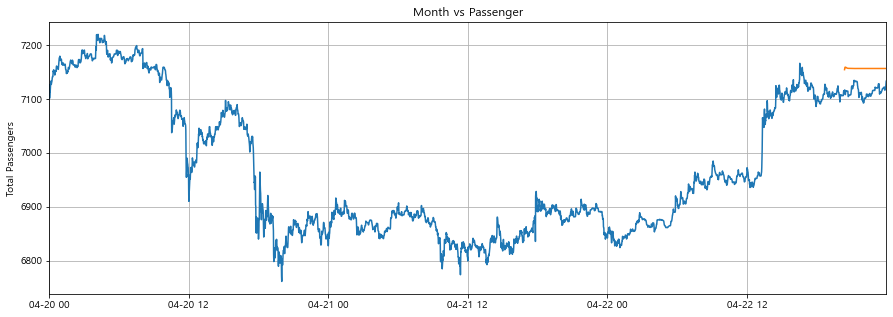

In [61]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['timestamp'],df['price'])
plt.plot(df['timestamp'][s:],actual_predictions)
plt.show()

In [70]:
actual_predictions.shape

(216, 1)

In [74]:
actual_predictions.reshape(216,)

array([7154.12795722, 7155.95318766, 7158.21510721, 7158.06974455,
       7158.65089464, 7158.54250109, 7158.41992648, 7158.36331155,
       7157.95225217, 7157.93700548, 7157.48812995, 7157.45736334,
       7157.13488775, 7157.05701489, 7156.89244359, 7156.77391291,
       7156.71612305, 7156.57392995, 7156.56054128, 7156.43944216,
       7156.44261172, 7156.38069597, 7156.38681651, 7156.37719852,
       7156.36501211, 7156.36430169, 7156.32708666, 7156.3226602 ,
       7156.28153787, 7156.29074599, 7156.27724803, 7156.29312316,
       7156.29517245, 7156.29582822, 7156.27099088, 7156.25314843,
       7156.23090685, 7156.21060526, 7156.21956747, 7156.21729959,
       7156.32369851, 7156.25648194, 7156.2969485 , 7156.24309327,
       7156.25607208, 7156.24112596, 7156.24331186, 7156.26164614,
       7156.22883024, 7156.23642626, 7156.2011239 , 7156.21178019,
       7156.25645461, 7156.28161984, 7156.26735681, 7156.28216632,
       7156.2899536 , 7156.30951745, 7156.31380729, 7156.32085

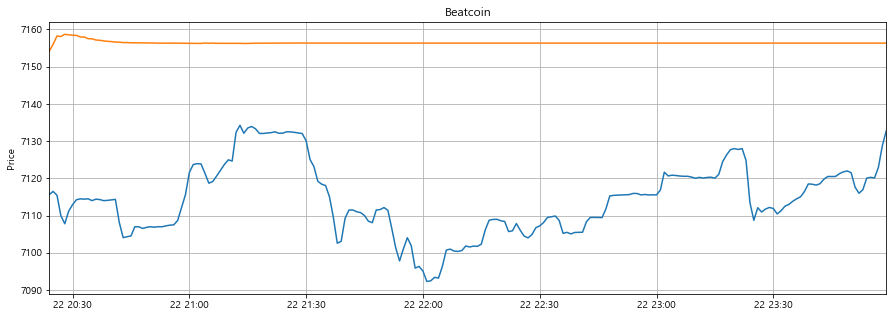

In [77]:
plt.title('Beatcoin')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(df['timestamp'][s:], df['price'][s:])
plt.plot(df['timestamp'][s:], actual_predictions.reshape(216,))
plt.show()